In [1]:
!pip install -U future

     |████████████████████████████████| 829kB 13.6MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=479ff3549d1929f7ae30f68c05724ad850deeac86e9daf464842c280631fbc4a
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-11-12 01:59:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-12 01:59:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-12 01:59:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [3]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt   sample_data


In [5]:
from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score


MAX_SEQ_LEN = 100
MAX_V_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10


print("Loading GloVe vectors...")
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec

print("Loaded %s vectors." % len(word2vec))


Loading GloVe vectors...
Loaded 400000 vectors.


In [6]:
from google.colab import files

uploaded = files.upload()

Saving annotations_sentiment.csv to annotations_sentiment.csv


In [12]:
# label text data 

print("Loading text data...")

# load sentiment data
train = pd.read_csv('annotations_sentiment.csv')
sentences = train["sentence"].fillna("DUMMY_VALUE").values
possible_labels = ["acceptance", "acceptance_self", "anger", "annoyance", "anxiety", "bliss", "calmness", "contentment", "delight", "delight_self", "disgust","disgust_self","dislike","dislike_self","eagerness", "ecstacy", "enthusiasm", "fear", "grief", "joy", "loathing", "loathing_self", "melancholy", "pleasantness", "pleasantness_self", "rage", "responsiveness", "sadness", "serenity", "terror"]
print("Number of possible labels: %s" % len(possible_labels))

targets = train[possible_labels].values

print("Max sequence length: %s" % max(len(sentence) for sentence in sentences))
print("Min sequence length: %s" % min(len(sentence) for sentence in sentences))
s = sorted(len(s) for s in sentences)
print("Median sequence length: %s" % s[len(s) // 2])

Loading text data...
Number of possible labels: 30
Max sequence length: 259
Min sequence length: 6
Median sequence length: 54


In [13]:
# word index

tokenizer = Tokenizer(num_words=MAX_V_SIZE)
tokenizer.fit_on_texts(sentences)
seqs = tokenizer.texts_to_sequences(sentences)
word2idx = tokenizer.word_index
print("Number of unique tokens: %s" % len(word2idx))


Number of unique tokens: 887


In [14]:
# N x T matrix

data = pad_sequences(seqs, maxlen=MAX_SEQ_LEN)
print("Shape of data tensor:", data.shape)



Shape of data tensor: (226, 100)


In [16]:
# embedding matrix

print("Filling GloVe vectors...")
num_words = min(MAX_V_SIZE, len(word2idx) + 1) # keras word indexes start at 1; 0 is reserved for padding
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_V_SIZE:
    # get() returns Null if not found
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # oov tokens will be zero
      embedding_matrix[i] = embedding_vector


Filling GloVe vectors...


In [22]:
# embedding layer

embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQ_LEN,
    trainable=False

)

In [23]:
# model definition

input_ = Input(shape=(MAX_SEQ_LEN,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)

In [24]:
# compile model

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [25]:
# fit model

print("Training 1D convnet with global maxpooling...")
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training 1D convnet with global maxpooling...
Epoch 1/10
2/2 [==============================] - 0s 131ms/step - loss: 0.6417 - accuracy: 0.1056 - val_loss: 0.4145 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 0s 34ms/step - loss: 0.3332 - accuracy: 0.0611 - val_loss: 0.3004 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 0s 31ms/step - loss: 0.2124 - accuracy: 0.1222 - val_loss: 0.2826 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 0s 33ms/step - loss: 0.1932 - accuracy: 0.0667 - val_loss: 0.2755 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 0s 32ms/step - loss: 0.1758 - accuracy: 0.1278 - val_loss: 0.2646 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 0s 32ms/step - loss: 0.1677 - accuracy: 0.1278 - val_loss: 0.2676 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 0s 32ms/step - loss: 0.1581 - accuracy: 0.150

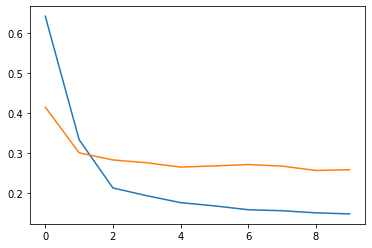

In [26]:
# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

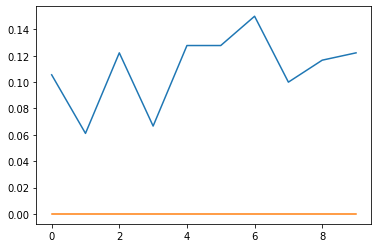

In [27]:
# plot acc per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_accuracy')

In [28]:
# plot mean auc for each label
p = model.predict(data)

aucs = []

for j in range(6):
  auc = roc_auc_score(targets[:,j], p[:,j])
  aucs.append(auc)

print(np.mean(aucs))

ValueError: ignored